# Classificador multi-rótulo - arXiv Paper Abstract

## arXiv Paper Abstract - Kaggle

Este é um conjunto de artigos contidos no arXiv com múltiplo rótulos.


## Exercícios


### Questão 1) Faça a leitura dos dados e implemente rotinas de pré-processamento:


#### a) Implemente e justifique suas ações em relação ao tratamento dos rótulos 


O primeiro passo é importar a biblioteca do pandas e realizar a leitura do arquivo. Nesta etapa já faço a remoção de valores duplicados.

In [93]:
import pandas as pd

data = pd.read_csv('arxiv_data.csv')
data = data.drop_duplicates().reset_index()

Os rótulos dos artigos estão na coluna `terms`. O valores desta coluna estão sendo reconhedidos como `str` porém o conteúdo de cada célula trata-se de lista de termos.

In [57]:
print(type(data.terms[0]))

<class 'str'>


In [58]:
print(data['terms'][0])

['cs.CV', 'cs.LG']


Para resolver este problema implementei a função `get_terms_list`. Esta função irá converter as strings para listas. Esta conversão é necessária para que o algortimo consiga reconhecer todas as categorias as quais um artigo pertence adequadamente.

Para selecionar todas as categorias corretaments utilizei uma regex que seleciona o padrão "texto.texto" em cada uma das linhas do dataset.

In [59]:
import re

def get_terms_list(terms):
    terms_list = []
    for terms in data.terms:
        terms = re.findall('\w+.\w+', terms)  # regex 
        terms_list.append(terms)
    return terms_list

data['terms'] = get_terms_list(data['terms'])

print(type(data.terms[0]))

<class 'list'>


Com as categorias em formato de lista o próximo passo é aplicatar a transformação MultiLabelBinarizer para ter-se uma matriz na qual cada coluna representa uma categoria existente.

In [60]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

mlb.fit(data['terms'])            
y = mlb.transform(data['terms'])

y = pd.DataFrame(y, columns = mlb.classes_)
y.head()

,0.b,00-02,00B25,00Bxx,03-04,03B52,03B65,03B70,03D10,03G10,...,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH,str-el,tells us,their Gait,using any
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


O próximo passo é manter os termos que aparecem uma quantidade mínima de vezes no conjunto de dados. Aqui vou escolher aqueles que aparecem pelo menos 100 vezes. O que equivale a aproximadamente 0,26% dos registros disponíveis.

In [61]:
def select_papers(data, y, freq_min=100):
    count_occurences = y.sum()
    cols_to_keep = count_occurences[count_occurences >= freq_min].index.values[:]
    y = y[cols_to_keep]

    terms_by_row = y.sum(axis=1)
    rows_to_keep = terms_by_row.index[terms_by_row >= 1]
    y = y.loc[rows_to_keep]
    data = data.loc[rows_to_keep]

    return data, y

data, y = select_papers(data, y)

#### b) Implemente e justifique suas ações em relação aos dados (titles e abstracts) 


Para os titles a abstracts será feita a redução de dimensionalidade. As palavras serão colocadas todas em minúsculas para normalizar o texto. Serão removidas as stopwords, depois aplicarei a lemmatização e stems. Todas estas etapas contribuiram para a remoção de conteúdo irrelevante para a classificação do texto e melhora da eficiência computacional.

In [62]:
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
tokenizer = RegexpTokenizer(r"\w+")

def remove_stopwords(tokens):               # Remove as stopwords
    tokens_cleaned = []
    for token in tokens:
        if token not in stop_words:
            tokens_cleaned.append(token)
    return tokens_cleaned

def normalize(text):
    text = text.lower()                     # passa o texto para minúsculas
    tokens = tokenizer.tokenize(text)       # separa o texto em tokens removendo pontuação
    tokens = remove_stopwords(tokens)       # remove as stopwords
    tokens_processed = []
    for token in tokens:
        token = lemmatizer.lemmatize(token) # extrai os lemmas
        token = stemmer.stem(token)         # remove sufixos e prefixos
        tokens_processed.append(token)
    return tokens_processed

Normalização dos títulos

In [63]:
def config_titles(text):
    return ' '.join(normalize(text))

titles = data.titles.apply(config_titles)

Normalizaçãod dos resumos.

In [64]:
def config_summary(text):
    return ' '.join(normalize(text))

summaries = data.summaries.apply(config_summary)

### Questão 2) Faça uma análise visual do dataset após o pré-processamento. Explore gráficos e/ou tabelas para mostrar a distribuição dos rótulos.

No gráfico abaixo são exibidas as 10 categorias de artigos mais frequentes do dataset do ArXiv. O dicionário abaixo têm o significado de cada sigla.

In [66]:
category_taxonomy = {
    'cs.CV': 'Ciência da Computação: Visão Computacional',
    'cs.LG': 'Ciência da Computação: Machine Learning',
    'stat.ML': 'Estatística: Machine Learning',
    'cs.AI': 'Ciência da Computação: Inteligência Artificial',
    'eess.IV': 'Engenharia Elétrica: Processamento de imagem e vídeo',
    'cs.RO': 'Ciência da Computação: Robótica',
    'cs.CL': 'Ciência da Computação: Processamento de linguagem natural',
    'cs.NE': 'Ciência da Computação: Computação neural e evolutica',
    'I.2': 'I.2',
    'cs.CR': 'Ciência da Computação: Criptografia e segurança'
}

Text(0.5, 1.0, 'As 10 categorias de artigos mais frequentes no ArXiv')

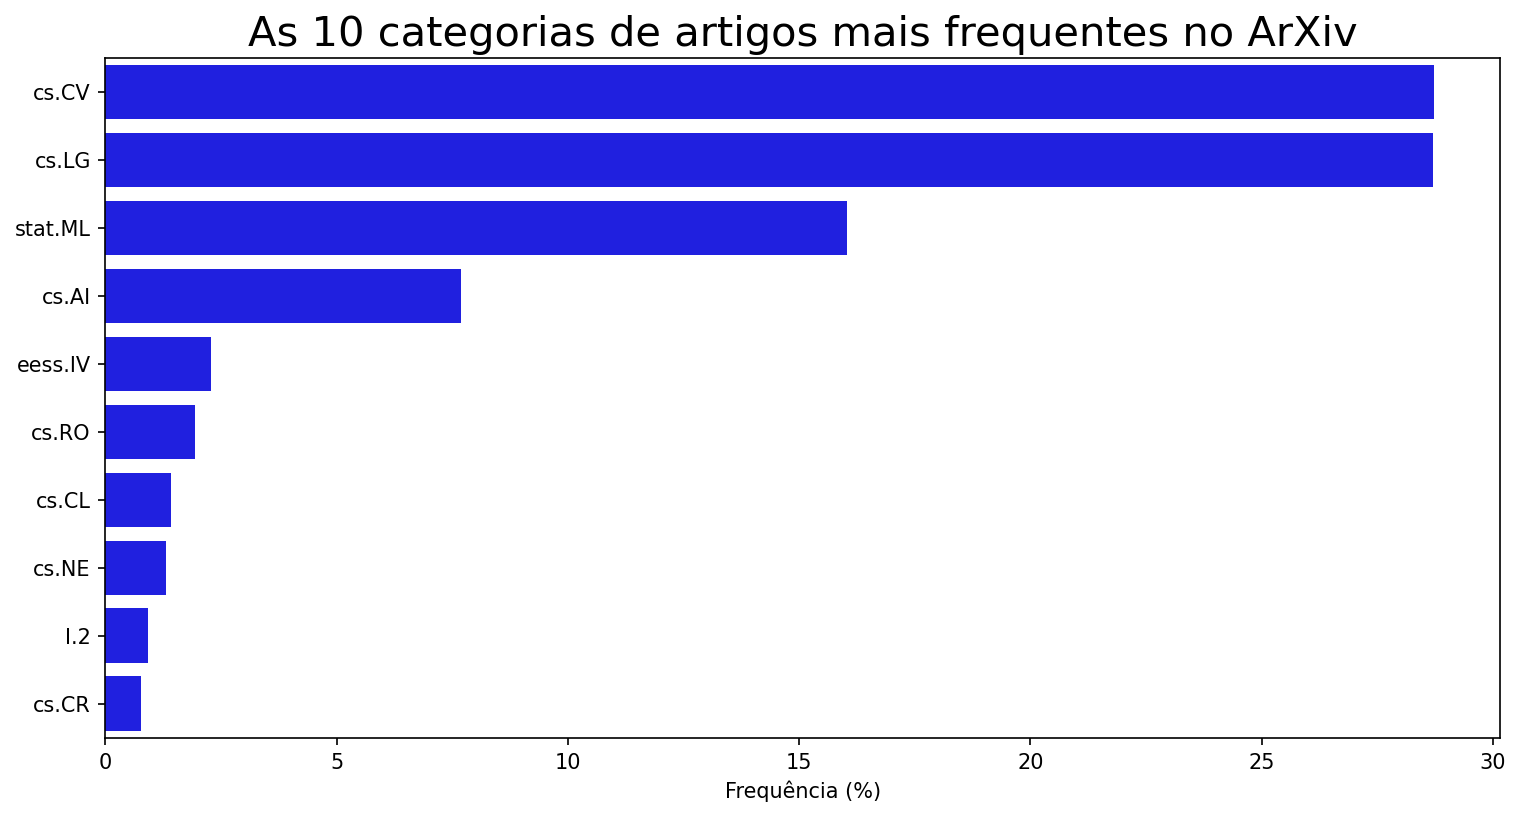

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

data = 100*(y.sum().to_frame() / y.sum().sum())
data['terms'] = data.index
plt.figure(figsize=(12, 6), dpi=150)
ax = sns.barplot(data=data.sort_values(by=0, ascending=False)[:10], y='terms', x=0, color='b')
ax.set_xlabel('Frequência (%)')
ax.set_ylabel('')
ax.set_title('As 10 categorias de artigos mais frequentes no ArXiv', fontsize=20)

Ciência da Computação (cs) é a área de estudo predominantes nos artigos deste dataset. E dentro da Ciência da Computação os temas mais comuns são Visão Computacional e Processamento de Linguagem Natural. Estes dois temas juntos estão presentes em quase 60% de todos os artigos disponíveis neste dataset. Tais resultados refletem a importância que se têm dados a esses temas nos últimos anos. Com o aumento da capacidade computacional foram desenvolvidos modelos avançados capazes de processarem a complexidade existente nestes temas.

### Questão 3) Escolha uma metodologia para extração de características considerando somente o título dos artigos científicos.

A função `extract_features` realiza a extração das características de um texto utilizando os métodos `CountVectorizer` e `TfidTransformer`.

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def extract_features(text_list, ngram_range=(2, 2)):
    vectorizer = CountVectorizer(analyzer='word', ngram_range=ngram_range)
    tfidf_transformer = TfidfTransformer()
    X_train_counts = vectorizer.fit_transform(text_list)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X = X_train_tfidf
    return X


Extração das características dos títulos.

In [69]:
X_features = extract_features(titles)

### Questão 4) Implemente o processo de classificação multi rótulos. Implemente 3 classificadores diferentes e compare suas performances. Escolha duas métricas distintas de sua escolha. Justifique suas escolhas e interprete os resultados.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

# Função para classificação de textos
def make_classification(X, y, text, model, test_size=0.2):
    split_validation = train_test_split(X, y, text, test_size=test_size, random_state=10)

    (X_train, X_test)       = split_validation[:2]
    (y_train, y_test)       = split_validation[2:4]
    (text_train, text_test) = split_validation[4:]

    clf = OneVsRestClassifier(model)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    return y_test, y_pred

Como métricas de avaliação foram escolhidas:
* **f1_score** : Que é a média harmônica entre Precisão e Recall. Varia de 0 a 1. Quanto mais próximo de 1 melhor o modelo.
* **ROC AUC** : Área da curva ROC. Mede a qualidade das previsões do modelo, independentemente do limiar de classificação.. Assume valores entre 0 e 1 em que 1 seria o resultado ideal. Bons modelos devem ter AUC maiores que 0.5.
* **log-loss** : Esta é a função de perda usada na regressão logística (multinomial) e em suas extensões, como redes neurais, definida como a probabilidade logarítmica negativa de um modelo logístico que retorna probabilidades y_pred para seus dados de treinamento y_true. Assume valores entre 0 e infinto. Quanto mais próximo de zero melhor o modelo.

Tais métricas foram escolhidas por serem recomendadas para o uso em casos onde há desbalanceamento de classes.

In [85]:
from sklearn.metrics import f1_score, roc_auc_score, log_loss

# Função para avaliação dos modelos
def evaluate_model(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    logloss = log_loss(y_true, y_pred)

    return pd.DataFrame([f1, roc_auc, logloss], index=['f1-score', 'ROC AUC', 'log-loss'])

Foram escolhidos três modelos de classificação:
* **SGDClassifier** : Modelo de classificação baseado em SVM.
* **LogisticRegression** : Modelo de classificação utilizando regressão logística
* **RidgeClassifier** : Esse classificador primeiro converte os valores de destino em {-1, 1} e, em seguida, trata o problema como uma tarefa de regressão (regressão de várias saídas no caso de multiclasse).

In [88]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

svm = SGDClassifier() 
y_test, y_pred = make_classification(X_features, y, titles, svm)
metrics = evaluate_model(y_test, y_pred)

lr = LogisticRegression()
y_test, y_pred2 = make_classification(X_features, y, titles, lr)
metrics = pd.concat([metrics, evaluate_model(y_test, y_pred2)], axis=1)

rc = RidgeClassifier()
y_test, y_pred2 = make_classification(X_features, y, titles, rc)
metrics = pd.concat([metrics, evaluate_model(y_test, y_pred2)], axis=1)

metrics.columns = ['SGD', 'Logistic', 'Ridge']
metrics

c:\Users\duart\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\duart\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

,SGD,Logistic,Ridge
f1-score,0.647178,0.657984,0.674472
ROC AUC,0.779097,0.781975,0.789817
log-loss,30.277879,29.923460,28.849260


Os resultados obtidos que o modelo utilizado o classificador Ridge teve os melhor desempenho em todas as métricas. Em segundo esta a Regressão Logísticas e por último o SGD.

### Questão 5) Replique os mesmos experimentos de extração de características e classificação considerando somente a coluna abstract.

Extração de características para os sumários.

In [73]:
X_features_summaries = extract_features(summaries)

Classificação dos artigos utilizandos as características dos resumos.

In [92]:
svm = SGDClassifier() 
y_test, y_pred = make_classification(X_features_summaries, y, summaries, svm)
metrics_summaries = evaluate_model(y_test, y_pred)

lr = LogisticRegression()
y_test, y_pred2 = make_classification(X_features_summaries, y, summaries, lr)
metrics_summaries = pd.concat([metrics_summaries, evaluate_model(y_test, y_pred2)], axis=1)

rc = RidgeClassifier()
y_test, y_pred2 = make_classification(X_features_summaries, y, summaries, rc)
metrics_summaries = pd.concat([metrics_summaries, evaluate_model(y_test, y_pred2)], axis=1)

metrics_summaries.columns = ['SGD', 'Logistic', 'Ridge']
metrics_summaries

,SGD,Logistic,Ridge
f1-score,0.695095,0.698763,0.714576
ROC AUC,0.787496,0.794490,0.805036
log-loss,29.264126,28.336505,26.942006


Novamente o rank da questão anterior foi mantido.

### Questão 6) Compare os resultados obtidos dos titles e abstracts. Qual atributo é mais discriminativo?

Os resultados obtidos utilizando os resumos foram melhores que aqueles obtidos utilizando apenas os títulos. Os resumos são mais discriminativos que os títulos devido a quantidade de informação que contém. Geralmente os títulos são formulados de maneira a serem chamativos e generalistas e acabam não refletindo todo o conteúdo dos artigos. Já os resumos são elaborados de forma a sintetizar todo o conteúdo do artigo. Nos resumos encontra-se as ideias principais do trabalho, palavras chaves, metodologia e conclusões. Todas estas informações reunidas são as responsáveis por tornarem os resumos como melhores discriminantes para identificar a qual ou quais categorias determinado artigo pertence.